In [3]:
import os
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import numpy as np

def load_data():
    return pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_clean.csv')

def load_past_results():
    path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_past.csv'
    if os.path.exists(path):
        return pd.read_csv(path)
    else:
        return pd.DataFrame()

def load_model(model_path):
    return load(model_path)

def check_preprocessing():
    prediction_data = load_data()
    past_results = load_past_results()

    # File paths and feature names
    ENCODER_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib'
    NONTREE_PREPROCESSOR_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\nontree_preprocessor.joblib'
    TREE_PREPROCESSOR_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\tree_preprocessor.joblib'
    MODEL_FOLDER = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models'

    CATEGORICAL_FEATURES = ['TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']
    feature_names = ['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 
                     'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 
                     'TEAM_ID_OPP', 'Home_Away'] #, 'MATCHUP_ID'

    # Split the models into tree and non-tree based models
    tree_models = ["xgboost", "decision_tree", "random_forest", "gradient_boosting", "adaboost"]
    non_tree_models = ["logistic_regression", "ridge_classifier", "sgd_classifier", "svm", "gaussian_naive_bayes", "k-neighbors_classifier", "mlp_classifier"]

    # Load and apply preprocessing
    ordinal_encoder = load_model(ENCODER_PATH)
    nontree_preprocessor = load_model(NONTREE_PREPROCESSOR_PATH)
    tree_preprocessor = load_model(TREE_PREPROCESSOR_PATH)
    


    #print(prediction_data[CATEGORICAL_FEATURES].head())
    #prediction_data[CATEGORICAL_FEATURES] = ordinal_encoder.transform(prediction_data[CATEGORICAL_FEATURES])

    # Replace the Streamlit model selection with a hardcoded model selection for checking
    model_selection = 'adaboost'  # Change this to check other models
    
    selected_model_path = os.path.join(MODEL_FOLDER, f"{model_selection}.joblib")

    try:
        selected_model = load_model(selected_model_path)
    except FileNotFoundError:
        print(f"Model {model_selection} not found.")
        return

    # Convert spaces to underscores and make all letters lowercase
    formatted_model_selection = model_selection.replace(' ', '_').lower()

    # Split the data into parts that need one-hot encoding and parts that don't
    categorical_data = prediction_data[CATEGORICAL_FEATURES]
    non_categorical_data = prediction_data.drop(columns=CATEGORICAL_FEATURES)

    #print(prediction_data.head())
    # Determine the type of preprocessor based on the model selected
    if formatted_model_selection in tree_models:
        #preprocessor = tree_preprocessor
        try:
            feature_names_from_model = tree_preprocessor.get_feature_names_out()  # Replace with nontree_preprocessor if needed
            categorical_data_encoded = ordinal_encoder.transform(categorical_data)
            #print(categorical_data_encoded)
            #non_categorical_data_encoded = tree_preprocessor.transform(non_categorical_data)
            #print(non_categorical_data)
            concat_data = pd.concat([non_categorical_data, pd.DataFrame(categorical_data_encoded, columns=CATEGORICAL_FEATURES, 
                                                                              index=non_categorical_data.index)], axis=1)
            #print(concat_data)
            #tree preprocessing
            preprocessed_data = tree_preprocessor.transform(concat_data)
            #print(preprocessed_data)
        except Exception as e:
            print(f"Error in preprocessing: {e}")
            return
    elif formatted_model_selection in non_tree_models:
        try:
            # Get feature names after preprocessing from the model
            feature_names_from_model = nontree_preprocessor.get_feature_names_out()
            #print("Expected columns after preprocessing:", feature_names_from_model)

            #print(prediction_data.head())
            # Transform the new data using the preprocessor
            preprocessed_data = nontree_preprocessor.transform(prediction_data)
            #print(preprocessed_data)
            #dense_preprocessed_df = pd.DataFrame(preprocessed_data.toarray(), columns=feature_names_from_model)
            # Assuming the transformation doesn't change the order or number of columns,
            # the feature names should now be directly comparable.
            
            # Get feature names from new preprocessed data
            # This assumes that the transformed data is a DataFrame; if it's a NumPy array, you'll need to convert it first.
            feature_names_from_new_data = pd.DataFrame(preprocessed_data.toarray(), columns=feature_names_from_model).columns.tolist()
            
            # Find extra and missing features
            extra_features = set(feature_names_from_new_data) - set(feature_names_from_model)
            missing_features = set(feature_names_from_model) - set(feature_names_from_new_data)
            
            if extra_features or missing_features:
                print("Extra features in new data:", extra_features)
                print("Missing features in new data:", missing_features)
                # You might want to handle these cases, perhaps by removing extra columns
                # or adding missing ones with default values.
            else:
                print("Feature names are aligned. You can proceed.")

        except Exception as e:
            print(f"Error in preprocessing: {e}")
            return
    else:
        print(f"Unknown model type for {formatted_model_selection}. Cannot proceed with preprocessing.")
        return


    
    #feature_names_from_model = nontree_preprocessor.get_feature_names_out()  # Replace with nontree_preprocessor if needed
    #preprocessed_data_df = pd.DataFrame(preprocessed_data.toarray(), columns=feature_names_from_model)
    #feature_names_from_new_data = preprocessed_data.columns.tolist()
    #extra_features = set(feature_names_from_new_data) - set(feature_names_from_model)
    #missing_features = set(feature_names_from_model) - set(feature_names_from_new_data)

    #print("Extra features in new data:", extra_features)
    #print("Missing features in new data:", missing_features)


    print("Preprocessing successful.")

    # Check if the number of features in the model matches the number of features in the preprocessed data
    def debug_feature_mismatch(model, preprocessed_data, feature_names_from_model):
        model_features_count = model.n_features_in_
        preprocessed_data_features_count = preprocessed_data.shape[1]

        if model_features_count != preprocessed_data_features_count:
            print(f"Model was trained on {model_features_count} features but preprocessed data has {preprocessed_data_features_count} features.")
            
            # If preprocessed_data is a DataFrame, you can get its feature names directly
            # Otherwise, you may use feature_names_from_model for the transformed data
            preprocessed_data_feature_names = preprocessed_data.columns.tolist() if isinstance(preprocessed_data, pd.DataFrame) else feature_names_from_model
            
            extra_features = set(preprocessed_data_feature_names) - set(feature_names_from_model)
            missing_features = set(feature_names_from_model) - set(preprocessed_data_feature_names)

            print(f"Extra features in prediction data: {extra_features}")
            print(f"Missing features in prediction data: {missing_features}")
        else:
            print("Feature count matches between the model and preprocessed data.")

    # Add this line before making a prediction
    debug_feature_mismatch(selected_model, preprocessed_data, feature_names_from_model)
    #print(feature_names_from_model)
    #preprocessed_data_feature_names = preprocessed_data.columns.tolist() if isinstance(preprocessed_data, pd.DataFrame) else feature_names_from_model
    #print(preprocessed_data_feature_names)
    print("Feature count check successful.")


    # Make predictions
    try:
        if formatted_model_selection == "svm":
            preprocessed_data = preprocessed_data.toarray()  # Convert to dense matrix for SVM

        predictions = selected_model.predict(preprocessed_data)
        prediction_data['PREDICTION'] = predictions
        #print(prediction_data.head())
    except Exception as e:
        print(f"Error in making predictions: {e}")
        return

    print("Prediction successful.")
    #print(prediction_data.head())
    #print(prediction_data.columns)
    #print(past_results.head())
    #print(past_results.columns)


    if not past_results.empty:
        try:
            # Merge the 'PREDICTION' column from prediction_data into past_results
            past_results = pd.merge(
                past_results, 
                prediction_data[['TEAM_ID', 'TEAM_ID_OPP', 'PREDICTION', 'YEAR', 'MONTH', 'DAY']], 
                on=['TEAM_ID', 'TEAM_ID_OPP', 'YEAR', 'MONTH', 'DAY'], 
                how='left'
            )
        except Exception as e:
            print(f"Error in merging predictions: {e}")
            return

    #sort past_results by date
    past_results = past_results.sort_values(by=['Date', 'MATCHUP_ID'], ascending=True)
    print(past_results.head())
    print ("Merging successful.")
    #past_results.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_past.csv', index=False)
    
    # Inverse transform the ordinal encoded categorical data for tree models
    #if formatted_model_selection in tree_models:
    #    try:
    #        prediction_data[CATEGORICAL_FEATURES] = ordinal_encoder.inverse_transform(prediction_data[CATEGORICAL_FEATURES])
    #    except Exception as e:
    #        print(f"Error in inverse transforming: {e}")
    #        return

    # Merge additional information from team_ids.csv into prediction_data
    df_team_ids = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\team_ids.csv')
    prediction_data = pd.merge(prediction_data, df_team_ids[['TEAM_ID', 'TEAM_NAME']], on='TEAM_ID', how='left')
    #print(prediction_data.head())

    # Remove matchup_id's that are the same as the ones in past_results if the past results are equal to the predicted results

    # Convert 'W' to 1 and 'L' to 0 in the 'ACTUAL_RESULT' column
    past_results['ACTUAL_RESULT_ENCODED'] = past_results['ACTUAL_RESULT'].map({'W': 1, 'L': 0})

    # Filter out rows with NaN values in either 'ACTUAL_RESULT_ENCODED' or 'PREDICTION'
    filtered_results = past_results.dropna(subset=['ACTUAL_RESULT_ENCODED', 'PREDICTION'])

    # Create a new column indicating whether each prediction was correct
    filtered_results['CORRECT_PREDICTION'] = np.where(
        filtered_results['ACTUAL_RESULT_ENCODED'] == filtered_results['PREDICTION'],
        1,
        0
    )

    # Calculate correct prediction percentage
    correct_prediction_percentage = (filtered_results['CORRECT_PREDICTION'].sum() / len(filtered_results)) * 100
    print(f'Correct Prediction Percentage: {correct_prediction_percentage:.2f}%')

    # Ensure the Date column is in datetime format
    
    filtered_results['Date'] = pd.to_datetime(filtered_results['Date'])

    # Plotting
    plt.figure(figsize=(10, 6))
    colors = np.where(filtered_results['CORRECT_PREDICTION']==1, 'g', 'r')
    plt.scatter(filtered_results['Date'], filtered_results['CORRECT_PREDICTION'], c=colors, alpha=0.5)
    plt.yticks([0, 1], ['Incorrect', 'Correct'])
    plt.title('Correct vs Incorrect Predictions over Time')
    plt.xlabel('Date')
    plt.ylabel('Prediction Accuracy')
    plt.grid(True)
    plt.show()
 

if __name__ == '__main__':
    check_preprocessing()  # Changed from main() to check_preprocessing()


KeyboardInterrupt: 

In [ ]:
import streamlit as st
import os
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import numpy as np

# File paths and feature names
DATA_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_clean.csv'
PAST_RESULTS_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_past.csv'
ENCODER_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib'
NONTREE_PREPROCESSOR_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\nontree_preprocessor.joblib'
TREE_PREPROCESSOR_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\tree_preprocessor.joblib'
MODEL_FOLDER = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models'

CATEGORICAL_FEATURES = ['TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']
FEATURE_NAMES = ['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 
                 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 
                 'TEAM_ID_OPP', 'Home_Away']

DISPLAY_FEATURES = ['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', ]


# Load data
@st.cache_data
def load_data():
    return pd.read_csv(DATA_PATH)

@st.cache_data
def load_past_results():
    if os.path.exists(PAST_RESULTS_PATH):
        return pd.read_csv(PAST_RESULTS_PATH)
    else:
        return pd.DataFrame()

@st.cache_resource
def load_model(model_path):
    return load(model_path)

# Main Streamlit App
def main():
    st.title('Machine Learning Model Tracking with Streamlit')

    # Model selection
    model_names = [f for f in os.listdir(MODEL_FOLDER) if f.endswith('.joblib')]
    selected_model_name = st.selectbox('Select Model', model_names)
    selected_model_path = os.path.join(MODEL_FOLDER, selected_model_name)
    model = load_model(selected_model_path)

    # Load data
    prediction_data = load_data()
    past_results = load_past_results()

    # Feature selection sliders
    st.subheader('Feature Selection')
    feature_dict = {}
    for feature in [f for f in FEATURE_NAMES if f in DISPLAY_FEATURES]:
        min_val, max_val = prediction_data[feature].min(), prediction_data[feature].max()
        feature_dict[feature] = st.slider(f'Select range for {feature}', float(min_val), float(max_val), (float(min_val), float(max_val)))

    # Filter the data
    filtered_data = prediction_data.copy()
    for feature, (min_val, max_val) in feature_dict.items():
        filtered_data = filtered_data[(filtered_data[feature] >= min_val) & (filtered_data[feature] <= max_val)]

    # Prediction and plotting
    st.subheader('Predictions vs Actual Results')
    if filtered_data.shape[0] > 0:
        X = filtered_data[FEATURE_NAMES]
        
        if 'ACTUAL_RESULT' in filtered_data.columns:
            y_actual = filtered_data['ACTUAL_RESULT']
        else:
            st.error("ACTUAL_RESULT not found in the dataset.")
            return

        y_pred = model.predict(X)
        
        # Adding date for x-axis
        x_date = filtered_data['Formatted_Date']
        
        fig, ax = plt.subplots()
        ax.scatter(x_date, y_actual, label='Actual')
        ax.scatter(x_date, y_pred, label='Predicted')
        plt.xticks(rotation=45)  # Optional, for better date label visibility
        plt.legend()
        st.pyplot(fig)
    else:
        st.write("No data available for the selected feature ranges.")

if __name__ == '__main__':
    main()

2023-10-14 10:34:15.101 No runtime found, using MemoryCacheStorageManager
2023-10-14 10:34:15.103 No runtime found, using MemoryCacheStorageManager


2023-10-24 05:50:27.829 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-24 05:50:27.831 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-24 05:50:27.832 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-24 05:50:28.529 
  command:

    streamlit run C:\Users\ghadf\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2023-10-24 05:50:29.432 No runtime found, using MemoryCacheStorageManager
2023-10-24 05:50:29.448 No runtime found, using MemoryCacheStorageManager
2023-10-24 05:50:29.501 No runtime found, using MemoryCacheStorageManager


Correct Prediction Percentage: 0.00%


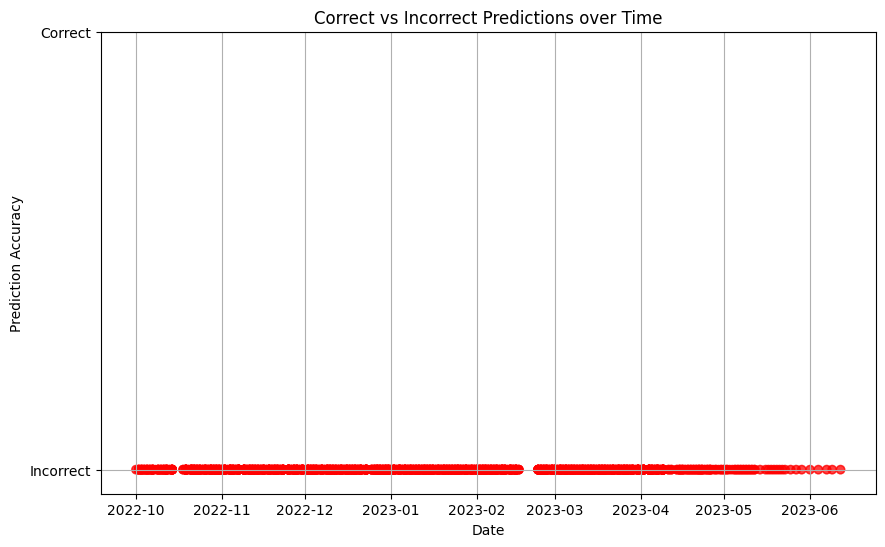

In [ ]:
import streamlit as st
import os
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import numpy as np

# File paths and feature names
DATA_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_clean.csv'
#using the preprocess data for the streamlit app and attaching the predictions to it
PAST_RESULTS_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_prepreprocess_data.csv'
TODAYS_GAMES = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_past.csv'
ENCODER_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib'
NONTREE_PREPROCESSOR_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\nontree_preprocessor.joblib'
TREE_PREPROCESSOR_PATH = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\tree_preprocessor.joblib'
MODEL_FOLDER = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models'

CATEGORICAL_FEATURES = ['TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']
FEATURE_NAMES = ['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 
                 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 
                 'TEAM_ID_OPP', 'Home_Away']

DISPLAY_FEATURES = ['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', ]

# Load data
@st.cache_data
def load_data():
    return pd.read_csv(DATA_PATH)

#load past data
@st.cache_data
def load_past_results():
    if os.path.exists(PAST_RESULTS_PATH):
        return pd.read_csv(PAST_RESULTS_PATH)
    else:
        return pd.DataFrame()
    
#load Today's games
@st.cache_data
def load_todays_games():
    if os.path.exists(TODAYS_GAMES):
        return pd.read_csv(TODAYS_GAMES)
    else:
        return pd.DataFrame()

@st.cache_resource
def load_model(model_path):
    return load(model_path)

# Split the models into tree and non-tree based models
tree_models = ["xgboost", "decision_tree", "random_forest", "gradient_boosting", "adaboost"]
non_tree_models = ["logistic_regression", "ridge_classifier", "sgd_classifier", "svm", "gaussian_naive_bayes", "k-neighbors_classifier", "mlp_classifier"]

# Load and apply preprocessing
ordinal_encoder = load_model(ENCODER_PATH)
nontree_preprocessor = load_model(NONTREE_PREPROCESSOR_PATH)
tree_preprocessor = load_model(TREE_PREPROCESSOR_PATH)



def ml_streamlit_app():
    st.title("NBA W/L Prediction Models")

    # Load Data
    prediction_data = load_data()  
    past_results = load_past_results()  
    todays_games = load_todays_games()

    # Model Selection
    model_options = ["xgboost", "decision_tree", "random_forest", "gradient_boosting", "adaboost",
                     "logistic_regression", "ridge_classifier", "sgd_classifier", "svm", 
                     "gaussian_naive_bayes", "k-neighbors_classifier", "mlp_classifier"]
    model_selection = st.selectbox("Select the model:", model_options)
    
    selected_model_path = os.path.join(MODEL_FOLDER, f"{model_selection}.joblib")

    try:
        selected_model = load_model(selected_model_path)
    except FileNotFoundError:
        print(f"Model {model_selection} not found.")
        return

    # Convert spaces to underscores and make all letters lowercase
    formatted_model_selection = model_selection.replace(' ', '_').lower()

    # Split the data into parts that need one-hot encoding and parts that don't
    categorical_data = prediction_data[CATEGORICAL_FEATURES]
    non_categorical_data = prediction_data.drop(columns=CATEGORICAL_FEATURES)

    #print(prediction_data.head())
    # Determine the type of preprocessor based on the model selected
    if formatted_model_selection in tree_models:
        #preprocessor = tree_preprocessor
        try:
            feature_names_from_model = tree_preprocessor.get_feature_names_out()  # Replace with nontree_preprocessor if needed
            categorical_data_encoded = ordinal_encoder.transform(categorical_data)
            #print(categorical_data_encoded)
            #non_categorical_data_encoded = tree_preprocessor.transform(non_categorical_data)
            #print(non_categorical_data)
            concat_data = pd.concat([non_categorical_data, pd.DataFrame(categorical_data_encoded, columns=CATEGORICAL_FEATURES, 
                                                                              index=non_categorical_data.index)], axis=1)
            #print(concat_data)
            #tree preprocessing
            preprocessed_data = tree_preprocessor.transform(concat_data)
            #print(preprocessed_data)
        except Exception as e:
            print(f"Error in preprocessing: {e}")
            return
    elif formatted_model_selection in non_tree_models:
        try:
            # Get feature names after preprocessing from the model
            feature_names_from_model = nontree_preprocessor.get_feature_names_out()
            #print("Expected columns after preprocessing:", feature_names_from_model)

            #print(prediction_data.head())
            # Transform the new data using the preprocessor
            preprocessed_data = nontree_preprocessor.transform(prediction_data)
            #print(preprocessed_data)
            #dense_preprocessed_df = pd.DataFrame(preprocessed_data.toarray(), columns=feature_names_from_model)
            # Assuming the transformation doesn't change the order or number of columns,
            # the feature names should now be directly comparable.
            
            # Get feature names from new preprocessed data
            # This assumes that the transformed data is a DataFrame; if it's a NumPy array, you'll need to convert it first.
            feature_names_from_new_data = pd.DataFrame(preprocessed_data.toarray(), columns=feature_names_from_model).columns.tolist()
            
            # Find extra and missing features
            extra_features = set(feature_names_from_new_data) - set(feature_names_from_model)
            missing_features = set(feature_names_from_model) - set(feature_names_from_new_data)
            
            if extra_features or missing_features:
                print("Extra features in new data:", extra_features)
                print("Missing features in new data:", missing_features)
                # You might want to handle these cases, perhaps by removing extra columns
                # or adding missing ones with default values.
            else:
                print("Feature names are aligned. You can proceed.")

        except Exception as e:
            print(f"Error in preprocessing: {e}")
            return
    else:
        print(f"Unknown model type for {formatted_model_selection}. Cannot proceed with preprocessing.")
        return

    # Prediction
    try:
        if model_selection == "svm":
            preprocessed_data = preprocessed_data.toarray()
        
        predictions = selected_model.predict(preprocessed_data)
        prediction_data['PREDICTION'] = predictions
        
    except Exception as e:
        st.error(f"Error in making predictions: {e}")
        return
    
    #filter saved_results for yesterday and today's games, to only update the correct predictions for today's games and results for yesterdays
    yesterday = pd.Timestamp.today() - pd.Timedelta(days=1)
    today = pd.Timestamp.today() #+ pd.Timedelta(days=1)
    
    #create a date column out of the year, month, and day columns
    prediction_data['Date'] = pd.to_datetime(prediction_data[['YEAR', 'MONTH', 'DAY']])
    prediction_data = prediction_data[(prediction_data['Date'] >= yesterday) & (prediction_data['Date'] <= today)]
    #print(prediction_data.head())

    # Merge the 'PREDICTION' column from prediction_data onto todays games before saving those results onto the past results
    try:
        todays_games = pd.merge(
            todays_games,
            prediction_data[['TEAM_ID', 'TEAM_ID_OPP', 'PREDICTION', 'YEAR', 'MONTH', 'DAY']],
            on=['TEAM_ID', 'TEAM_ID_OPP', 'YEAR', 'MONTH', 'DAY'],
            how='left'
        )
    except Exception as e:
        st.error(f"Error in merging predictions: {e}")
        return
    #drop nan predictions
    todays_games = todays_games.dropna(subset=['PREDICTION'])
    #print(todays_games.head())

    # Show Results before attaching because they have nothing to attach to in the new dataset until day of
    st.dataframe(todays_games)

    #add in a datetime column for when time this code was run 
    todays_games['date_prediction_recorded'] = pd.Timestamp.today()
    today = pd.Timestamp.today()

    # Merge the 'PREDICTION' column from todays games/prediction data into past_results (preprocessed data)
    try:
        past_results = pd.merge(
            past_results,
            todays_games[['TEAM_ID', 'TEAM_ID_OPP', 'PREDICTION', 'YEAR', 'MONTH', 'DAY', 'date_prediction_recorded']],
            on=['TEAM_ID', 'TEAM_ID_OPP', 'YEAR', 'MONTH', 'DAY'],
            how='left'
        )
    except Exception as e:
        st.error(f"Error in merging predictions: {e}")
        return
    
    #sorting by and dropping by the date_prediction_recorded makes it so that we can run multiple times and we'll only go with the latest results 
    # (from today's games so it can't do previous results, done in the morning's before games are played)
    # improvement: add an if function so predictions can't be recorded after games are played no matter what)
    #sort past_results by date_prediction_recorded so that when we drop duplicates, we drop the old ones
    past_results = past_results.sort_values(by=['date_prediction_recorded', 'MATCHUP_ID'], ascending=True)
    #drop duplicate rows
    past_results = past_results.drop_duplicates(subset=['TEAM_ID', 'TEAM_ID_OPP', 'YEAR', 'MONTH', 'DAY'], keep='last')

    # Create a new column indicating whether each prediction was correct
    past_results['CORRECT_PREDICTION'] = np.where(
        past_results['WL_encoded'] == past_results['PREDICTION'],
        1,
        0
    )
    past_results['Date'] = pd.to_datetime(past_results[['YEAR', 'MONTH', 'DAY']])
    #print(past_results.head())  
    
    # Save the results back to CSV
    past_results.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_predictions_results.csv')

    # Calculate correct prediction percentage
    correct_prediction_percentage = (past_results['CORRECT_PREDICTION'].sum() / len(past_results)) * 100
    print(f'Correct Prediction Percentage: {correct_prediction_percentage:.2f}%')
    st.write(f'Correct Prediction Percentage: {correct_prediction_percentage:.2f}%')

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = np.where(past_results['CORRECT_PREDICTION']==1, 'g', 'r')
    ax.scatter(past_results['Date'], past_results['CORRECT_PREDICTION'], c=colors, alpha=0.5)
    plt.yticks([0, 1], ['Incorrect', 'Correct'])
    plt.title('Correct vs Incorrect Predictions over Time')
    plt.xlabel('Date')
    plt.ylabel('Prediction Accuracy')
    plt.grid(True)

    st.pyplot(fig)

if __name__ == '__main__':
    ml_streamlit_app()


In [ ]:
#Man vs Machine
import streamlit as st
import os
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import numpy as np

# File paths and feature names
tree_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\tree_season_pred.csv'
non_tree_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\non_tree_season_pred.csv'
ltsm_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\ltsm_season_pred.csv'

past_results_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_prepreprocess_data.csv'
#load past results
past_results = pd.read_csv(past_results_path)
print(past_results.head())

# Load data
#@st.cache_data
#load tree models and only pull in _prediction columns, matchup_id, and team_id
tree_pred_data = pd.read_csv(tree_pred_path)
non_tree_pred_data = tree_pred_data[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'XGBoost_PREDICTION', 'Decision Tree_PREDICTION', 'Random Forest_PREDICTION'
                                     , 'Gradient Boosting_PREDICTION', 'AdaBoost_PREDICTION']]
#print(tree_pred_data.head())

#load non tree data and only pull in _prediction columns, matchup_id, and team_id
non_tree_pred_data = pd.read_csv(non_tree_pred_path)
non_tree_pred_data = non_tree_pred_data[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'MLP Classifier_PREDICTION', 'K-Neighbors Classifier_PREDICTION'
                                         , 'SVM_PREDICTION', 'SGD Classifier_PREDICTION', 'Ridge Classifier_PREDICTION', 'Logistic Regression_PREDICTION']]
#print(tree_pred_data.head())

#load ltsm data and only pull in renamed, ltsm predictions column
ltsm_pred_data = pd.read_csv(ltsm_pred_path)
#print(tree_pred_data.head())
#print(ltsm_pred_data.head())
#change Prediction column name in ltsm_pred_data to ltsm_prediction
ltsm_pred_data = ltsm_pred_data.rename(columns={'PREDICTION': 'ltsm_PREDICTION'})
#only pull in Date, Matchup_ID, and Team_ID columns from ltsm_pred_data
ltsm_pred_data = ltsm_pred_data[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'ltsm_PREDICTION']]

# merge each predictions dataset into one dataframe by Date, Matchup_ID, and Team_ID
#tree_pred_data = tree_pred_data.drop(columns=['Unnamed: 0'])
#non_tree_pred_data = non_tree_pred_data.drop(columns=['Unnamed: 0'])
#ltsm_pred_data = ltsm_pred_data.drop(columns=['Unnamed: 0'])

#merge tree and non tree
tree_non_tree_pred_data = pd.merge(tree_pred_data, non_tree_pred_data, on=['Date', 'MATCHUP_ID', 'TEAM_NAME'], how='left')
#merge tree_non_tree and ltsm
all_pred_data = pd.merge(tree_non_tree_pred_data, ltsm_pred_data, on=['Date', 'MATCHUP_ID', 'TEAM_NAME'], how='left')

#print(all_pred_data.head()) 


   SEASON_ID     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME   GAME_ID  \
0      12022  1610612737               ATL  Atlanta Hawks  12200023   
1      12022  1610612737               ATL  Atlanta Hawks  12200036   
2      12022  1610612737               ATL  Atlanta Hawks  12200052   
3      12022  1610612737               ATL  Atlanta Hawks  12200067   
4      22022  1610612737               ATL  Atlanta Hawks  22200005   

    GAME_DATE      MATCHUP  MIN  PTS  FGM  ...  AST%_DIFF  ORtg_DIFF  \
0  2022-10-06  ATL vs. MIL  241  123   47  ...  22.191051 -12.837480   
1  2022-10-08    ATL @ MIL  240  118   44  ...  29.297912 -10.478984   
2  2022-10-12    ATL @ CLE  238   99   30  ...  30.361168   1.162340   
3  2022-10-14    ATL @ NOP  240  111   42  ...  33.951128   9.884244   
4  2022-10-19  ATL vs. HOU  240  117   45  ...  24.843537  -8.542983   

   PER%_DIFF  PTS_DIFF  PTS_PER_MIN_DIFF  YEAR  MONTH  DAY  WL_encoded  WL  
0  -0.267827        10          0.039540  2022     10    6     

In [1]:

# File paths and feature names
tree_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\tree_season_pred.csv'
non_tree_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\non_tree_season_pred.csv'
ltsm_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\ltsm_season_pred.csv'
ltsm_seq_pred_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\ltsm_seq_season_pred.csv'
past_results_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_current_season_prediction_tracker.csv'
votes_data_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\voter_pred.csv'
# Load predictions directly from the compiled CSV
all_data_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\new_season_predictions\predictions_combined.csv'

import streamlit as st
import pandas as pd
import plotly.express as px
from sklearn.metrics import accuracy_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import openai
import os

#Take out predictions with the Same value for model so we only track valuable predictions
def validate_predictions(data):
    prediction_columns = [
        'XGBoost_PREDICTION', 'Decision Tree_PREDICTION', 'Random Forest_PREDICTION', 
        'Gradient Boosting_PREDICTION', 'AdaBoost_PREDICTION', 'MLP Classifier_PREDICTION', 
        'K-Neighbors Classifier_PREDICTION', 'SVM_PREDICTION', 'SGD Classifier_PREDICTION', 
        'Ridge Classifier_PREDICTION', 'Logistic Regression_PREDICTION', 'ltsm_PREDICTION', 'ltsm_seq_PREDICTION'
    ]
    
    # Iterate over each prediction column to validate
    for col in prediction_columns:
        # Calculate the sum of predictions for each matchup within the column
        data[f'{col}_sum'] = data.groupby(['Date', 'MATCHUP_ID'])[col].transform('sum')
        
        # Identify rows where the sum of predictions is not equal to 1
        invalid_mask = data[f'{col}_sum'] != 1
        
        # Set predictions to NaN for rows where the sum is not 1
        data.loc[invalid_mask, col] = np.nan
    
    # Drop the temporary sum columns
    sum_columns = [f'{col}_sum' for col in prediction_columns]
    data = data.drop(columns=sum_columns)
    
    return data


# Data Loading Functions
def load_tree_data(path):
    return pd.read_csv(path)[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'XGBoost_PREDICTION', 'Decision Tree_PREDICTION', 'Random Forest_PREDICTION', 'Gradient Boosting_PREDICTION', 'AdaBoost_PREDICTION']]

def load_non_tree_data(path):
    return pd.read_csv(path)[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'MLP Classifier_PREDICTION', 'K-Neighbors Classifier_PREDICTION', 'SVM_PREDICTION', 'SGD Classifier_PREDICTION', 'Ridge Classifier_PREDICTION', 'Logistic Regression_PREDICTION']]

def load_ltsm_data(path):
    ltsm_data = pd.read_csv(path)
    ltsm_data = ltsm_data.rename(columns={'PREDICTION': 'ltsm_PREDICTION'})
    return ltsm_data[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'ltsm_PREDICTION']]

def load_ltsm_seq_data(path):
    ltsm_seq_data = pd.read_csv(path)
    ltsm_seq_data = ltsm_seq_data.rename(columns={'PREDICTION': 'ltsm_seq_PREDICTION'})
    return ltsm_seq_data[['Date', 'MATCHUP_ID', 'TEAM_NAME', 'ltsm_seq_PREDICTION']]

def load_past_results(path):
    return pd.read_csv(path)

# Load voter data and remove the index column if it exists
try:
    votes_data = pd.read_csv(votes_data_path).drop(columns=['Unnamed: 0'], errors='ignore')
except FileNotFoundError:
    votes_data = pd.DataFrame(columns=['Date', 'MATCHUP_ID', 'TEAM_NAME', 'Votes'])

# Aggregate votes by Date, MATCHUP_ID, and TEAM_NAME
aggregated_votes = votes_data.groupby(['Date', 'MATCHUP_ID', 'TEAM_NAME']).sum().reset_index().rename(columns={'Votes': 'voter_predictions'})
#print(aggregated_votes.head())

# Merging function
def merge_data(tree_data, non_tree_data, ltsm_seq_data, ltsm_data):
    # Perform the merges
    tree_non_tree = pd.merge(tree_data, non_tree_data, on=['Date', 'MATCHUP_ID', 'TEAM_NAME'], how='left')
    tree_non_tree_ltsm = pd.merge(tree_non_tree, ltsm_seq_data, on=['Date', 'MATCHUP_ID', 'TEAM_NAME'], how='left')
    all_data = pd.merge(tree_non_tree_ltsm, ltsm_data, on=['Date', 'MATCHUP_ID', 'TEAM_NAME'], how='left')
    
    # Validate predictions before merging with votes
    validated_data = validate_predictions(all_data)
    
    # Now merge with votes data
    all_data_with_votes = pd.merge(validated_data, aggregated_votes, on=['Date', 'MATCHUP_ID', 'TEAM_NAME'], how='left')
    
    return all_data_with_votes



all_data = pd.read_csv(all_data_path)

# Function to calculate the daily correct percentage
def calculate_daily_correct_percentage(data, model):
    data['correct'] = data[f'{model}_PREDICTION'] == data['WL_encoded']
    daily_correct = data.groupby('Date')['correct'].mean().reset_index()
    return daily_correct.sort_values('Date')

#*******************************chatbot add on***********************************
# Initialize session state for messages at the top level to ensure it's always done.
#st.session_state.setdefault("messages", [{"role": "system", "content": "Warming up on the court! 🏀 Ready to assist and share some hoops wisdom. Pass the ball, and let's get this conversation rolling!"}])

# Set the OpenAI API key.
#openai.api_key = st.secrets["openai_key"]


# Function to generate initial prompt for the chatbot based on the model's predictions
def generate_initial_prompt(past_data_with_predictions):
    # You could summarize the data or just take the most recent predictions
    prompt = "Ask me anything about the NBA before 2021 or anything about LSTM Models"
    #latest_predictions = past_data_with_predictions.iloc[-1]  # Assuming the latest predictions are at the end
    #prompt = f"Today is {datetime.now().strftime('%Y-%m-%d')}. Here are the latest NBA game predictions: "
    #prompt += f"{latest_predictions['TEAM_NAME']} prediction is {latest_predictions['ltsm_seq_PREDICTION']} based on the Chronos Predictor. "
    #prompt += "What do you think about these predictions?"
    return prompt

def chatbot_sidebar(initial_prompt):
    # Initialize session state for chat messages if not already done
    if "chat_messages" not in st.session_state:
        st.session_state["chat_messages"] = [{"role": "system", "content": initial_prompt}]

    with st.sidebar:
        st.title("🏀 NBA Chatbot")
        # Display previous messages
        for msg in st.session_state["chat_messages"]:
            st.text_area(label=msg["role"], value=msg["content"], height=100, disabled=True)

        # User input for the chatbot
        user_input = st.text_input("Ask the chatbot about the NBA predictions:")

        if user_input:
            # Append user's message to the messages list
            st.session_state["chat_messages"].append({"role": "user", "content": user_input})

            # Request a completion from the model (this should be replaced with your own API call)
            # Note: You'll need to handle API calls and errors appropriately
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=st.session_state["chat_messages"]
            )
            response_text = response.choices[0].message["content"].strip()

            # Append the model's response to the messages list
            st.session_state["chat_messages"].append({"role": "assistant", "content": response_text})

            # Display the response
            st.text_area(label="Assistant", value=response_text, height=100, disabled=True)

#*******************************chatbot add on***********************************

def main():
    st.title("Man vs Machine: NBA Predictions")

    # Descriptive introduction
    st.markdown("""
        Welcome to the NBA Predictions app, where the power of human intuition meets the precision of machine learning. 
        Here, we feature two unique Long-Short-Term-Models (LSTM) that predict the outcomes of NBA games.:
        
        - **Chronos Predictor**: A LSTM model that leverages the sequence of the last 5 games to capture the momentum and dynamics of NBA teams. This model understands that the context of previous games can be vital in determining the outcome of the next game.
        
        - **Aeolus Forecaster**: A standard LSTM model that provides predictions based on current game data without the sequence memory of past games. It's named after the Greek deity of wind, symbolizing the swift and dynamic nature of its predictions.
        
        - **Regression Forecaster**: A linear regression model that predicts the outcome of NBA games based on how many points will be scored. This model is named after the type of  Recurrent Neural Network (RNN) that is uses
                
        Compare these advanced AI predictions with human votes to see if man or machine has the upper hand in predicting the outcomes of NBA games.
    """)

    
    # Load and merge data
    tree_data = load_tree_data(tree_pred_path)
    non_tree_data = load_non_tree_data(non_tree_pred_path)
    ltsm_data = load_ltsm_data(ltsm_pred_path)
    ltsm_seq_data = load_ltsm_seq_data(ltsm_seq_pred_path)
    #all_data = merge_data(tree_data, non_tree_data, ltsm_data, ltsm_seq_data)
    all_data = pd.read_csv(all_data_path)
    past_results = load_past_results(past_results_path)
    # Sidebar for navigation
    app_mode = st.sidebar.selectbox("Choose the app mode", ["Man vs Machine", "All Predictions", "Voter Predictions"])
    
    if app_mode == "Voter Predictions":
        st.subheader('Upcoming NBA Games (LSTM Predictions)')
        
        # Load previous votes if available
        if 'votes_data' not in st.session_state:
            try:
                st.session_state['votes_data'] = pd.read_csv(votes_data_path)
            except FileNotFoundError:
                st.session_state['votes_data'] = pd.DataFrame(columns=['MATCHUP_ID', 'TEAM_NAME', 'Votes'])
        
        today_date = datetime.now().strftime('%Y-%m-%d')  # Get today's date
        selected_date = today_date  # Allow voting only for today's games
        matchups_on_selected_date = ltsm_data[ltsm_data['Date'] == selected_date]

        # Group by matchup_id to show both teams in the same section
        grouped = matchups_on_selected_date.groupby('MATCHUP_ID')

        for matchup_id, group in grouped:
            for _, matchup in group.iterrows():
                st.write(f"{matchup['TEAM_NAME']}: LSTM: {matchup['ltsm_PREDICTION']} LSTM:")

            # Voting
            selected_team = st.selectbox(f"Who will win {matchup_id}?", group['TEAM_NAME'].tolist())

            if st.button(f"Vote for {selected_team}"):
                # Iterate through the teams in the matchup
                for team_name in group['TEAM_NAME'].tolist():
                    # Record a '0' for the selected team and a '1' for the other team
                    vote_value = 0 if team_name == selected_team else 1
                    # Find the existing vote record for this matchup and team
                    existing_vote = st.session_state['votes_data'].loc[
                        (st.session_state['votes_data']['MATCHUP_ID'] == matchup_id) & 
                        (st.session_state['votes_data']['TEAM_NAME'] == team_name) & 
                        (st.session_state['votes_data']['Date'] == selected_date)
                    ]
                    
                    # Check if the team already has a vote record for this matchup on this date
                    if existing_vote.empty:
                        # If no existing vote, append the new row
                        new_row = {'Date': selected_date, 'MATCHUP_ID': matchup_id, 'TEAM_NAME': team_name, 'Votes': vote_value}
                        st.session_state['votes_data'] = pd.concat([st.session_state['votes_data'], pd.DataFrame([new_row])], ignore_index=True)
                    else:
                        # If vote exists, check if it is the same as before
                        if existing_vote['Votes'].iloc[0] != vote_value:
                            # If different, update the vote
                            st.session_state['votes_data'].loc[existing_vote.index, 'Votes'] = vote_value
                            st.success(f"Your vote for {team_name} has been updated.")
                        else:
                            # If the same, inform the user
                            st.info(f"You have already voted for {team_name} as {'winning' if vote_value == 0 else 'losing'} this matchup.")

                # Save the updated votes to CSV
                st.session_state['votes_data'].to_csv(votes_data_path, index=False)
                st.rerun()  # Rerun the app to reflect the updated votes

            st.write("---")

    
    elif app_mode == "All Predictions":
        st.subheader('All Predictions')
        #sort by date and reset index
        all_data = all_data.sort_values(by=['Date'], ascending=False)
        all_data = all_data.reset_index(drop=True)
        st.write(all_data)

    if app_mode == "Man vs Machine":
        st.subheader('Man vs Machine: Model Performance')

        models = [
            "XGBoost", "Decision Tree", "Random Forest",
            "Gradient Boosting", "AdaBoost", "MLP Classifier",
            "K-Neighbors Classifier", "SVM", "SGD Classifier",
            "Ridge Classifier", "Logistic Regression", "ltsm",
            "ltsm_seq", "linreg_team_point", "linreg_wl"
        ]
        accuracies = {}
        mae_values = {}

        for model in models:
            # Filter out NaN values for both predictions and actual results
            filtered_df = all_data.dropna(subset=['WL_encoded', f"{model}_PREDICTION"])
            # For the linear regression model, calculate MAE
            if "linreg_team_point" in model:
                mae_values[model] = mean_absolute_error(filtered_df['PTS'], filtered_df[f"{model}_PREDICTION"])
            else:
                # For classification models, calculate accuracy
                accuracies[model] = accuracy_score(filtered_df['WL_encoded'], filtered_df[f"{model}_PREDICTION"])

        # Combine the accuracy and MAE dictionaries into a dataframe
        accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
        mae_df = pd.DataFrame(list(mae_values.items()), columns=['Model', 'MAE'])

        # Merge the two dataframes on the 'Model' column
        performance_df = pd.merge(accuracy_df, mae_df, on='Model', how='outer')

        # If you want to display 'linreg' as 'Linear Regression' in your table
        performance_df['Model'] = performance_df['Model'].replace({
            'linreg_team_point': 'Linear Regression NN (Team Points)',
            'linreg_wl': 'Linear Regression NN (Win/Loss)',
            'ltsm': 'Chronos Predictor',
            'ltsm_seq': 'Aeolus Forecaster'
        })
        #change Accuracy column into percentages
        performance_df['Accuracy'] = performance_df['Accuracy'].map("{:.2%}".format)

        #change MAE to 2 decimal places
        performance_df['MAE'] = performance_df['MAE'].map("{:.2f}".format)

        # reorder columns so included models come first in the table
        included_models = ['Chronos Predictor', 'Aeolus Forecaster', 'Linear Regression NN (Win/Loss)', 'Linear Regression NN (Team Points)']
        performance_df = performance_df.reindex(performance_df['Model'].isin(included_models).sort_values(ascending=False).index)

        st.write(performance_df)

        included_models = ['ltsm', 'ltsm_seq', 'linreg_wl']
        all_model_data = pd.DataFrame()

        for model in included_models:
            model_data = all_data.dropna(subset=['WL_encoded', f"{model}_PREDICTION"])
            model_data['Model'] = model  # Add a column for the model name
            daily_correct_percentage = calculate_daily_correct_percentage(model_data, model)
            daily_correct_percentage['Model'] = model  # Add a column for the model name
            all_model_data = pd.concat([all_model_data, daily_correct_percentage], ignore_index=True)

        # Using Plotly to create an interactive plot
        fig = px.scatter(all_model_data, x='Date', y='correct', color='Model',
                         title='Daily Correct Percentage of Included Models',
                         labels={'correct': 'Correct Percentage'},
                         hover_data={'Model': True})

        fig.update_traces(mode='lines+markers')
        fig.update_layout(legend_title_text='Model')
        fig.update_yaxes(tickformat=".1%")  # Format the y-axis ticks as percentages

        # Display the plot in Streamlit
        st.plotly_chart(fig)

        # Generate initial prompt for the chatbot
        #initial_prompt = generate_initial_prompt(performance_df)

        # Display the chatbot in the sidebar
        #chatbot_sidebar(initial_prompt)
        

# Run the main function
if __name__ == "__main__":
    main()




2023-11-15 15:22:19.639 
  command:

    streamlit run C:\Users\ghadf\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
C:\Users\ghadf\AppData\Local\Temp\ipykernel_19212\1255869990.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['Model'] = model  # Add a column for the model name
C:\Users\ghadf\AppData\Local\Temp\ipykernel_19212\1255869990.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['correct'] = data[f'{model}_PREDICTION'] == data['WL_encoded']
C